In [8]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "../data"

SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
ALL_POSITIONS = ["dom_hand", "nondom_hand"]

TRAIN_POSITIONS = ["dom_hand"]
TEST_POSITIONS = ["nondom_hand"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

In [9]:
def load_selected_csvs(base_dir):
    dfs = []
    for activity in SELECTED_ACTIVITIES:
        for position in ALL_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(os.path.basename(csv_path))[0]
                dfs.append(df)
    print(f"Loaded {len(dfs)} recordings | Activities={SELECTED_ACTIVITIES} | Positions={ALL_POSITIONS}")
    return dfs

def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

def extract_features(window, cols):
    feats = []
    for c in cols:
        x = window[c].values

        # Time-domain features
        feats.extend([
            np.mean(x),
            np.std(x),
            np.min(x),
            np.max(x),
            np.sqrt(np.mean(x ** 2)),
            np.sum(np.abs(x)) / len(x)
        ])

        # Frequency-domain features
        fft_vals = np.fft.rfft(x)
        fft_mag = np.abs(fft_vals) / len(fft_vals)
        feats.extend([
            np.mean(fft_mag),
            np.std(fft_mag),
            np.max(fft_mag),
            np.sum(fft_mag)
        ])
    return feats

def build_dataset(dfs, feature_cols, selected_positions):
    X, y, positions = [], [], []
    for df in dfs:
        if df["phone_position"].iloc[0] not in selected_positions:
            continue
        df = trim_df(df)
        if df is None:
            continue
        for w in sliding_windows(df):
            X.append(extract_features(w, feature_cols))
            y.append(w["activity"].iloc[0])
            positions.append(w["phone_position"].iloc[0])
    return np.array(X), np.array(y), np.array(positions)

In [10]:
def evaluate_svm(X_train, y_train, X_test, y_test, title):
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC())
    ])

    param_grid = {
        "svm__kernel": ["rbf"],
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", 0.01, 0.001]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    print(f"\nBest parameters for {title}:")
    print(grid.best_params_)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"\n=== {title} ===")
    unique_labels = np.unique(y_test)
    print(classification_report(y_test, y_pred, labels=unique_labels, digits=4, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, cmap="Oranges")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "precision": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "recall": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "f1": f1_score(y_test, y_pred, average="macro", zero_division=0)
    }

Loaded 40 recordings | Activities=['sit', 'walk', 'run', 'stairs'] | Positions=['dom_hand', 'nondom_hand']
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for SVM Raw Device-Frame Features:
{'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

=== SVM Raw Device-Frame Features ===
              precision    recall  f1-score   support

         run     1.0000    0.0200    0.0392       250
         sit     1.0000    0.6400    0.7805       250
      stairs     0.3612    1.0000    0.5307       255
        walk     0.3284    0.1760    0.2292       250

    accuracy                         0.4617      1005
   macro avg     0.6724    0.4590    0.3949      1005
weighted avg     0.6708    0.4617    0.3956      1005



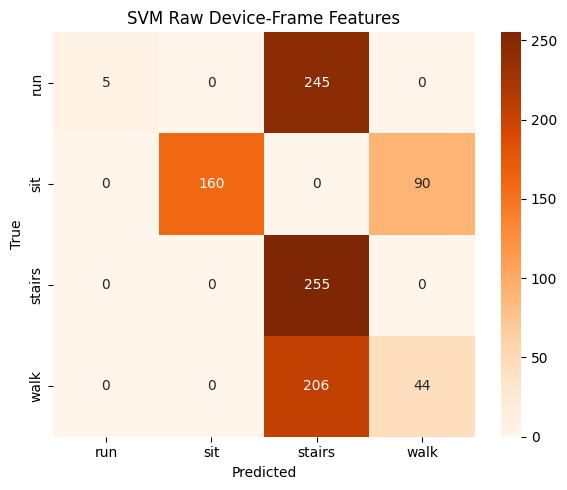

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for SVM GFT Axis-wise Features:
{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

=== SVM GFT Axis-wise Features ===
              precision    recall  f1-score   support

         run     0.0000    0.0000    0.0000       250
         sit     0.0000    0.0000    0.0000       250
      stairs     0.2540    1.0000    0.4051       255
        walk     1.0000    0.0040    0.0080       250

    accuracy                         0.2547      1005
   macro avg     0.3135    0.2510    0.1033      1005
weighted avg     0.3132    0.2547    0.1048      1005



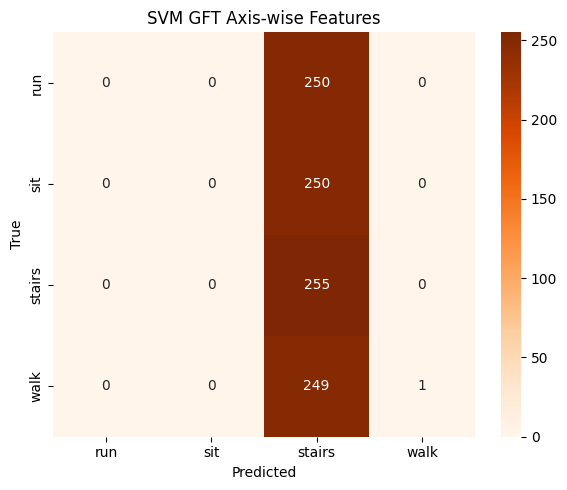


========== SUMMARY ==========
Activities: ['sit', 'walk', 'run', 'stairs']
Train Positions: ['dom_hand']
Test Positions: ['nondom_hand']
Raw Device-Frame Features: {'precision': 0.6723870026637352, 'recall': 0.459, 'f1': 0.3948918370614661}
GFT Axis-wise Features: {'precision': 0.313496015936255, 'recall': 0.251, 'f1': 0.10326288175336779}


In [11]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)

    X_train_raw, y_train_raw, _ = build_dataset(recordings, RAW_FEATURES, TRAIN_POSITIONS)
    X_test_raw, y_test_raw, _ = build_dataset(recordings, RAW_FEATURES, TEST_POSITIONS)

    raw_metrics = evaluate_svm(
        X_train_raw, y_train_raw,
        X_test_raw, y_test_raw,
        "SVM Raw Device-Frame Features"
    )

    X_train_gft, y_train_gft, _ = build_dataset(recordings, GFT_FEATURES, TRAIN_POSITIONS)
    X_test_gft, y_test_gft, _ = build_dataset(recordings, GFT_FEATURES, TEST_POSITIONS)

    gft_metrics = evaluate_svm(
        X_train_gft, y_train_gft,
        X_test_gft, y_test_gft,
        "SVM GFT Axis-wise Features"
    )

    print("\n========== SUMMARY ==========")
    print("Activities:", SELECTED_ACTIVITIES)
    print("Train Positions:", TRAIN_POSITIONS)
    print("Test Positions:", TEST_POSITIONS)
    print("Raw Device-Frame Features:", raw_metrics)
    print("GFT Axis-wise Features:", gft_metrics)